In [41]:
library(lme4)
options(rgl.useNULL=TRUE)
library(LMERConvenienceFunctions)

library(ggplot2)
options(jupyter.plot_mimetypes = 'image/png')
library(repr)
options(repr.plot.width=6, repr.plot.height=6)

library(car)
library(MASS)

library(vcd)

# Body length

In this notebook, we document our various steps taken to study the effect of the overall length of a session on the body length (number of characters) of the very first comment. Note that we only do this on a sample of 1 mio. data points here.

In [42]:
#no zeros in the outcome variable
data = read.csv("/home/psinger/Reddit-depletion/data/sample.csv", header=TRUE)

In [18]:
nrow(data)

[1] 1000000

## Data inspection

We start by getting a better feeling of our data. Note that body_length represents count data.

We limit the data to only consider the first comment of each session.

In [43]:
idx = data$session_index==1

In [44]:
data_first = data[idx,]

In [23]:
nrow(data_first)

[1] 502586

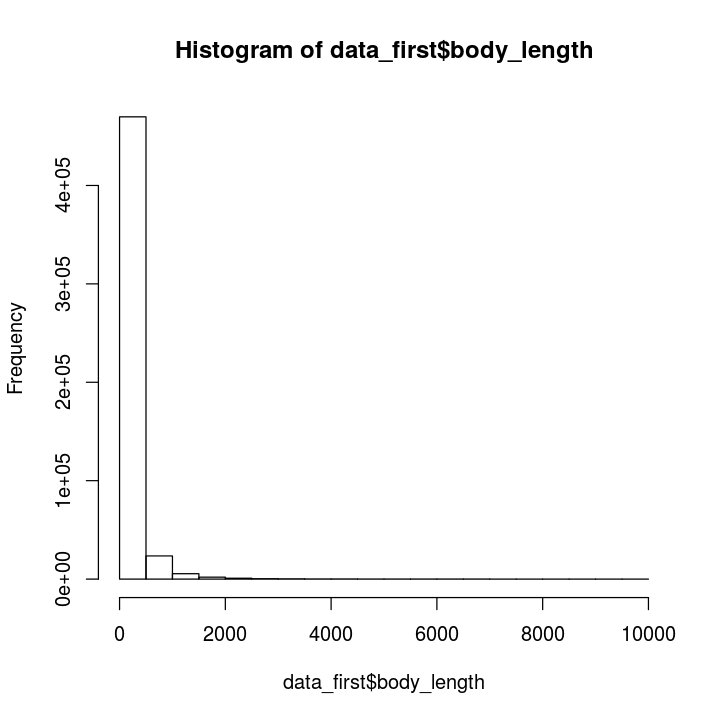

In [35]:
hist(data_first$body_length)

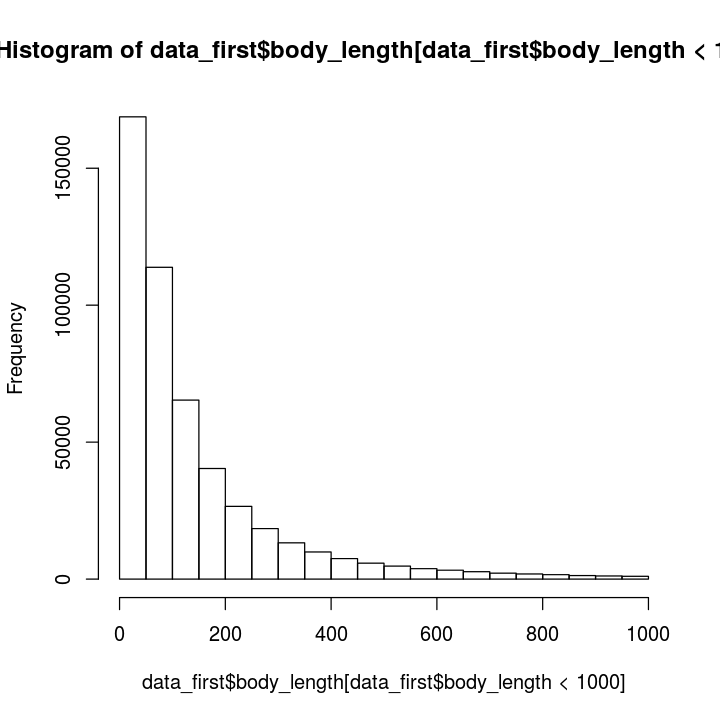

In [36]:
hist(data_first$body_length[data_first$body_length<1000])

## Regression model

We use mixed-effects models where in the most basic form (that we analyze in this notebook), we are interested in studying body_length ~ 1 + session_comments + (1|author) where body_length is the text length of the first comment, session_comments refers to the session length and author represents the redditor username.

### Linear mixed-effects regression

Even though we cannot expect a simple linear mixed-effects regression to be an appropriate model for our count data, we start with it.

In [24]:
m_lmer = lmer(body_length~1+session_comments+(1|author), data=data_first, REML=FALSE)

In [25]:
summary(m_lmer)

Linear mixed model fit by maximum likelihood  ['lmerMod']
Formula: body_length ~ 1 + session_comments + (1 | author)
   Data: data_first

     AIC      BIC   logLik deviance df.resid 
 7142757  7142802 -3571375  7142749   502582 

Scaled residuals: 
   Min     1Q Median     3Q    Max 
-5.386 -0.397 -0.254  0.052 32.230 

Random effects:
 Groups   Name        Variance Std.Dev.
 author   (Intercept) 13257    115.1   
 Residual             74482    272.9   
Number of obs: 502586, groups:  author, 370780

Fixed effects:
                 Estimate Std. Error t value
(Intercept)      165.3815     0.5041   328.1
session_comments   1.4784     0.1291    11.4

Correlation of Fixed Effects:
            (Intr)
sssn_cmmnts -0.497

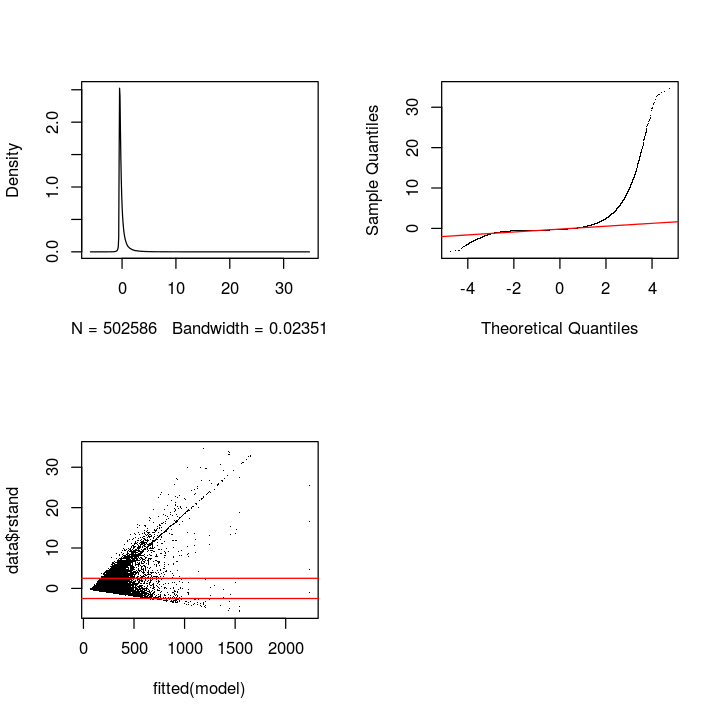

In [26]:
mcp.fnc(m_lmer)

What we can see in above plot is, that the residuals do not appear to be normally distributed and we can see clear heteroskedasticity. Thus, as expected, a linear model does not provide a good fit here.

### Linear mixed-effects regression (log-transform)

Next, let us take the log of the response variable and repeat a linear regression.

In [27]:
m_lmer_log = lmer(log(body_length)~1+session_comments+(1|author), data=data_first, REML=FALSE)

In [28]:
summary(m_lmer_log)

Linear mixed model fit by maximum likelihood  ['lmerMod']
Formula: log(body_length) ~ 1 + session_comments + (1 | author)
   Data: data_first

      AIC       BIC    logLik  deviance  df.resid 
1639203.9 1639248.4 -819597.9 1639195.9    502582 

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-4.4228 -0.5491  0.0247  0.5914  3.8708 

Random effects:
 Groups   Name        Variance Std.Dev.
 author   (Intercept) 0.3381   0.5815  
 Residual             1.2145   1.1020  
Number of obs: 502586, groups:  author, 370780

Fixed effects:
                  Estimate Std. Error t value
(Intercept)      4.3755455  0.0021358  2048.7
session_comments 0.0084841  0.0005387    15.7

Correlation of Fixed Effects:
            (Intr)
sssn_cmmnts -0.485

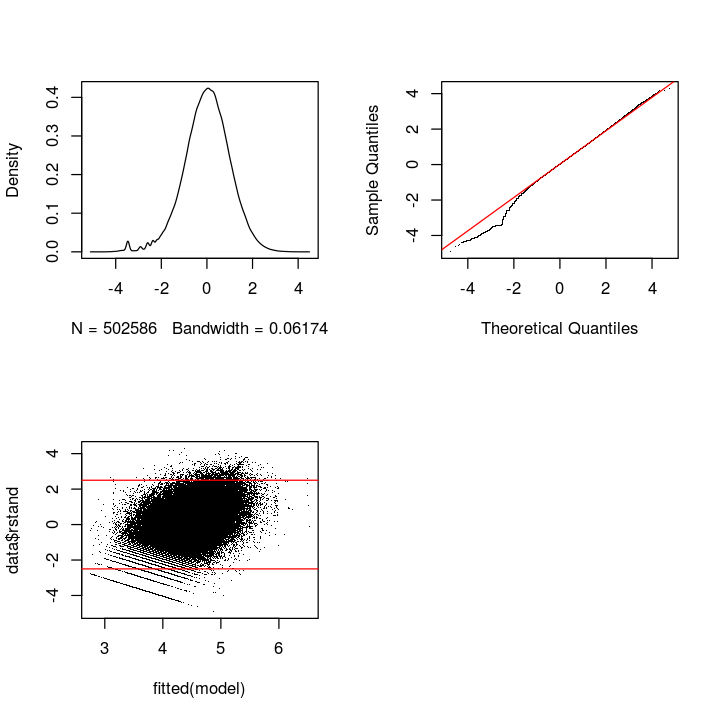

In [29]:
mcp.fnc(m_lmer_log)

That looks pretty good already. For completeness, we proceed by looking at generalized linear mixed-effects models though as they usually capture count data quite well.

### Poisson GLMER

Let us start with a Poisson GLMER, which is a main choice when working with count data.

In [29]:
m_poisson = glmer(body_length~1+session_comments+(1|author),data=data_first,family=poisson())

Warning message:
In checkConv(attr(opt, "derivs"), opt$par, ctrl = control$checkConv, : Model failed to converge with max|grad| = 0.00197872 (tol = 0.001, component 1)Warning message:
In checkConv(attr(opt, "derivs"), opt$par, ctrl = control$checkConv, : Model is nearly unidentifiable: very large eigenvalue
 - Rescale variables?

In [30]:
summary(m_poisson)

Generalized linear mixed model fit by maximum likelihood (Laplace
  Approximation) [glmerMod]
 Family: poisson  ( log )
Formula: body_length ~ 1 + session_comments + (1 | author)
   Data: data_first

      AIC       BIC    logLik  deviance  df.resid 
 25133739  25133772 -12566866  25133733    502583 

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-70.403  -0.481  -0.012   0.057 158.615 

Random effects:
 Groups Name        Variance Std.Dev.
 author (Intercept) 1.335    1.155   
Number of obs: 502586, groups:  author, 370780

Fixed effects:
                  Estimate Std. Error z value Pr(>|z|)    
(Intercept)      4.451e+00  1.911e-03  2329.6   <2e-16 ***
session_comments 8.847e-03  5.674e-05   155.9   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Correlation of Fixed Effects:
            (Intr)
sssn_cmmnts -0.055
convergence code: 0
Model failed to converge with max|grad| = 0.00197872 (tol = 0.001, component 1)
Model is nearly unidentifia

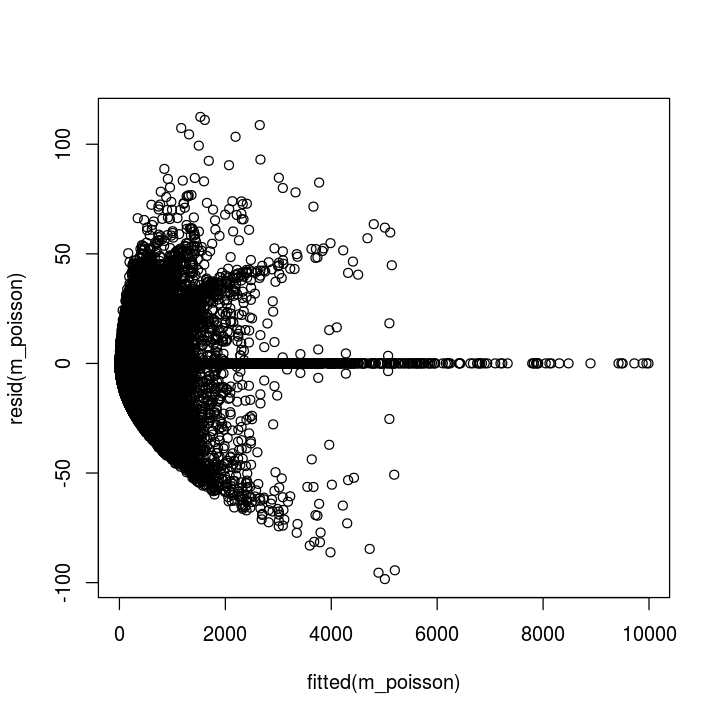

In [31]:
plot(fitted(m_poisson),resid(m_poisson))

The convergence message shows low magnitude and for such large data this might be a false positive as emphasized in the lme4 docu. 

The residual plots for generalized linear models are generally quite difficult to interpret as the residuals do not necessarily need to follow a normal distribution any longer. However, the fitted vs. residual plots shows a typical pattern for Poisson regression with curvilinear traces. What we can do though as a first step here, is to look at overdispersion (see http://glmm.wikidot.com/faq).

In [38]:
overdisp_fun <- function(model) {
  ## number of variance parameters in 
  ##   an n-by-n variance-covariance matrix
  vpars <- function(m) {
    nrow(m)*(nrow(m)+1)/2
  }
  model.df <- sum(sapply(VarCorr(model),vpars))+length(fixef(model))
  rdf <- nrow(model.frame(model))-model.df
  rp <- residuals(model,type="pearson")
  Pearson.chisq <- sum(rp^2)
  prat <- Pearson.chisq/rdf
  pval <- pchisq(Pearson.chisq, df=rdf, lower.tail=FALSE)
  c(chisq=Pearson.chisq,ratio=prat,rdf=rdf,p=pval)
}

In [39]:
overdisp_fun(m_poisson)

chisq        ratio          rdf            p 
1.888639e+07 3.757865e+01 5.025830e+05 0.000000e+00

As expected, we have to deal with overdispersion. There are generally some ways of doing so: (i) adding an individual-level random effect or (ii) using a negative binomial model or (iii) using quasi likelihood. Let us start with the first option.

In [40]:
data_first$obs<-factor(seq.int(nrow(data_first)))
m_poisson2 = glmer(body_length~1+session_comments+(1|author)+(1|obs),data=data_first,family=poisson())

Warning message:
In checkConv(attr(opt, "derivs"), opt$par, ctrl = control$checkConv, : Model failed to converge with max|grad| = 0.00112348 (tol = 0.001, component 1)Warning message:
In checkConv(attr(opt, "derivs"), opt$par, ctrl = control$checkConv, : Model is nearly unidentifiable: very large eigenvalue
 - Rescale variables?

In [41]:
summary(m_poisson2)

Generalized linear mixed model fit by maximum likelihood (Laplace
  Approximation) [glmerMod]
 Family: poisson  ( log )
Formula: body_length ~ 1 + session_comments + (1 | author) + (1 | obs)
   Data: data_first

     AIC      BIC   logLik deviance df.resid 
 6052838  6052883 -3026415  6052830   502582 

Scaled residuals: 
     Min       1Q   Median       3Q      Max 
-1.56470 -0.08726  0.00130  0.04089  0.12608 

Random effects:
 Groups Name        Variance Std.Dev.
 obs    (Intercept) 1.1226   1.060   
 author (Intercept) 0.3294   0.574   
Number of obs: 502586, groups:  obs, 502586; author, 370780

Fixed effects:
                  Estimate Std. Error z value Pr(>|z|)    
(Intercept)      4.3931582  0.0020833  2108.7   <2e-16 ***
session_comments 0.0083523  0.0005246    15.9   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Correlation of Fixed Effects:
            (Intr)
sssn_cmmnts -0.484
convergence code: 0
Model failed to converge with max|grad| = 0.

In [42]:
overdisp_fun(m_poisson2)

chisq        ratio          rdf            p 
1.878136e+04 3.736974e-02 5.025820e+05 1.000000e+00

Great, the overdispersion problem is gone. The results (coefficients) are very similar to the previous models though.

For completeness, we also want to utilize a negative binomial family though by first using the nb functionality provided in lme4.

In [43]:
m_nb = glmer.nb(body_length~1+session_comments+(1|author),data=data_first)

Warning message:
In checkConv(attr(opt, "derivs"), opt$par, ctrl = control$checkConv, : Model failed to converge with max|grad| = 0.00197872 (tol = 0.001, component 1)Warning message:
In checkConv(attr(opt, "derivs"), opt$par, ctrl = control$checkConv, : Model is nearly unidentifiable: very large eigenvalue
 - Rescale variables?Warning message:
In checkConv(attr(opt, "derivs"), opt$par, ctrl = control$checkConv, : Model failed to converge with max|grad| = 0.786934 (tol = 0.001, component 1)Warning message:
In checkConv(attr(opt, "derivs"), opt$par, ctrl = control$checkConv, : Model is nearly unidentifiable: very large eigenvalue
 - Rescale variables?Warning message:
In checkConv(attr(opt, "derivs"), opt$par, ctrl = control$checkConv, : Model failed to converge with max|grad| = 0.00264043 (tol = 0.001, component 1)Warning message:
In checkConv(attr(opt, "derivs"), opt$par, ctrl = control$checkConv, : Model is nearly unidentifiable: very large eigenvalue
 - Rescale variables?Warning mess

In [45]:
summary(m_nb)

Generalized linear mixed model fit by maximum likelihood (Laplace
  Approximation) [glmerMod]
 Family: Negative Binomial(1.2819)  ( log )
Formula: body_length ~ 1 + session_comments + (1 | author)
   Data: data_first

     AIC      BIC   logLik deviance df.resid 
 6076638  6076682 -3038315  6076630   502582 

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-1.1299 -0.6229 -0.1994  0.4146  7.8739 

Random effects:
 Groups Name        Variance Std.Dev.
 author (Intercept) 0.4793   0.6923  
Number of obs: 502586, groups:  author, 370780

Fixed effects:
                  Estimate Std. Error z value Pr(>|z|)    
(Intercept)      4.6862294  0.0022593  2074.2   <2e-16 ***
session_comments 0.0108661  0.0005621    19.3   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Correlation of Fixed Effects:
            (Intr)
sssn_cmmnts -0.475
convergence code: 0
Model failed to converge with max|grad| = 0.00292953 (tol = 0.001, component 1)
Model is nearly uni

We end up with multiple convergence warnings (not shown); the coefficients are quite similar to our previous observations though. Note that this model also takes a very long time to fit for this sample of 1 mio. data points; it does not really scale for larger data which in our case consists of more than 50 mio. data points.

As a consequence, let us next also fit a negative binomial regression, but this time we use quasi likelihood.

In [46]:
#just for initialization
init = glm.nb(body_length~1+session_comments,data=data_first)

In [47]:
init$theta

[1] 0.8153596

In [48]:
m_pql_nb = glmmPQL(body_length~1+session_comments, random = list(~1 | author), data = data_first, family = negative.binomial(theta=init$theta))

iteration 1
iteration 2
iteration 3
iteration 4
iteration 5
iteration 6
iteration 7
iteration 8
iteration 9
iteration 10


In [50]:
summary(m_pql_nb)

Linear mixed-effects model fit by maximum likelihood
 Data: data_first 
  AIC BIC logLik
   NA  NA     NA

Random effects:
 Formula: ~1 | author
        (Intercept)  Residual
StdDev:   0.5965164 0.8128293

Variance function:
 Structure: fixed weights
 Formula: ~invwt 
Fixed effects: body_length ~ 1 + session_comments 
                    Value    Std.Error     DF  t-value p-value
(Intercept)      4.712745 0.0018674328 370779 2523.649       0
session_comments 0.010783 0.0004594766 131805   23.468       0
 Correlation: 
                 (Intr)
session_comments -0.469

Standardized Within-Group Residuals:
       Min         Q1        Med         Q3        Max 
-2.8883073 -0.6417017 -0.2258876  0.4128097 11.8418703 

Number of Observations: 502586
Number of Groups: 370780 

Again, very similar results.

## Final model choice

Given our extensive analysis regarding the appropriate model for our data, we conclude that regardless of our model choice, the coefficients and subsequent inference are very similar. Nonetheless, we will proceed with a linear model on the log-transformed body_length due to the appropriate diagnostic plots, the simplicity of the model and the high mean og body_length.

## Significance of effects

Now that we have decided on a model, we want to extend our inference. First, we want to study the significance of the fixed effects as well as potential additional random effects. 

There are several options for determining the significance of a fixed effect on the model. For example, a common approach is to use the ratio of the slope to its standard error and then use a t-test for determining its significance. Alternatively, one can also use F-tests for contrasting simpler to more complex models. Both methods require a specification of the degrees of freedom though which is not trivial in mixed models; methods such as the Satterthwaite approximation or Kenward-Roger approximation can be used for that task. 
As stated in Baayen 2008, we can also directly use the t-statistics given to derive statistical significance. Because we have a huge dataset, a t-statistic above 2 can be regarded as significant at the 5\% level in a two-tailed test. You can derive this directly from the results above.

However, here, we follow an approach used for comparing models: the Bayesian Information Criterion (alternatively we could also work with AIC or LRT). Basically, the idea is to specify different (in this case nested) models that successively incorporate additional fixed or random effects and then compare their BIC scores. The lower the BIC, the better a model is (above a small threshold).

The baseline model we start with is:

body_length = 1 + (1|author)

The reason why we incorporate the random effect for author from the beginning is that this is necessary based on the design of the experiment. Also, as pointed out in http://glmm.wikidot.com/faq, you should not compare the fit of a (g)lmer with one from a (g)lm.

Okay, so let us get the BIC for the baseline model.

In [51]:
m1 = lmer(log(body_length)~1+(1|author), data = data_first, REML=FALSE)

In [52]:
summary(m1)

Linear mixed model fit by maximum likelihood  ['lmerMod']
Formula: log(body_length) ~ 1 + (1 | author)
   Data: data_first

      AIC       BIC    logLik  deviance  df.resid 
1639449.8 1639483.2 -819721.9 1639443.8    502583 

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-4.4194 -0.5543  0.0271  0.5919  3.8626 

Random effects:
 Groups   Name        Variance Std.Dev.
 author   (Intercept) 0.3377   0.5811  
 Residual             1.2156   1.1025  
Number of obs: 502586, groups:  author, 370780

Fixed effects:
            Estimate Std. Error t value
(Intercept) 4.391875   0.001868    2352

Next, let us incorporate the session length.

In [45]:
m2 = lmer(log(body_length)~1+session_comments+(1|author), data = data_first, REML=FALSE)

In [54]:
summary(m2)

Linear mixed model fit by maximum likelihood  ['lmerMod']
Formula: log(body_length) ~ 1 + session_comments + (1 | author)
   Data: data_first

      AIC       BIC    logLik  deviance  df.resid 
1639203.9 1639248.4 -819597.9 1639195.9    502582 

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-4.4228 -0.5491  0.0247  0.5914  3.8708 

Random effects:
 Groups   Name        Variance Std.Dev.
 author   (Intercept) 0.3381   0.5815  
 Residual             1.2145   1.1020  
Number of obs: 502586, groups:  author, 370780

Fixed effects:
                  Estimate Std. Error t value
(Intercept)      4.3755455  0.0021358  2048.7
session_comments 0.0084841  0.0005387    15.7

Correlation of Fixed Effects:
            (Intr)
sssn_cmmnts -0.485

Based on the lower BIC we can clearly see that the incorporation of the session length improves our model.

We stop at this point as our scope of interest is covered. However, one can arbitrarily extend the existing model.
For example, one might also argue that it is necessary to incorporate a random effect for the intercept based on different subreddits.

In [55]:
m3 = lmer(log(body_length)~1+session_comments+(1|author)+(1|subreddit), data = data_first, REML=FALSE)

In [56]:
summary(m3)

Linear mixed model fit by maximum likelihood  ['lmerMod']
Formula: log(body_length) ~ 1 + session_comments + (1 | author) + (1 |  
    subreddit)
   Data: data_first

      AIC       BIC    logLik  deviance  df.resid 
1591821.3 1591876.9 -795905.6 1591811.3    502581 

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-4.3999 -0.5522  0.0344  0.5993  5.2153 

Random effects:
 Groups    Name        Variance Std.Dev.
 author    (Intercept) 0.2130   0.4615  
 subreddit (Intercept) 0.2879   0.5366  
 Residual              1.1543   1.0744  
Number of obs: 502586, groups:  author, 370780; subreddit, 13987

Fixed effects:
                  Estimate Std. Error t value
(Intercept)      4.4334037  0.0068428   647.9
session_comments 0.0092621  0.0005175    17.9

Correlation of Fixed Effects:
            (Intr)
sssn_cmmnts -0.130

Again, the BIC shows an improvement in the model. Yet, the inference on the fixed effects does not change. For complexity reasons, we neglect the random effect for the subreddit for the complete data.

### Outliers

We also want to check for robustness when removing outliers.

In [46]:
data_first_limit <- romr.fnc(m2, data_first, trim = 2.5)$data

n.removed = 9514 
percent.removed = 1.893009 


In [47]:
m2_limit = lmer(log(body_length)~1+session_comments+(1|author),data=data_first_limit, REML=FALSE)

In [48]:
summary(m2_limit)

Linear mixed model fit by maximum likelihood  ['lmerMod']
Formula: log(body_length) ~ 1 + session_comments + (1 | author)
   Data: data_first_limit

     AIC      BIC   logLik deviance df.resid 
 1521034  1521078  -760513  1521026   493068 

Scaled residuals: 
     Min       1Q   Median       3Q      Max 
-2.93768 -0.58939  0.00671  0.60174  2.77225 

Random effects:
 Groups   Name        Variance Std.Dev.
 author   (Intercept) 0.3411   0.5841  
 Residual             0.9684   0.9840  
Number of obs: 493072, groups:  author, 365610

Fixed effects:
                  Estimate Std. Error t value
(Intercept)      4.4134038  0.0019915  2216.1
session_comments 0.0084851  0.0005023    16.9

Correlation of Fixed Effects:
            (Intr)
sssn_cmmnts -0.483

Not much changed.

## REML

Until now, we have fitted the models using ML as this allowed us to compare models with each other. To be sure regarding the consistency of our coefficient estimations, we will now also quickly fit the model with REML.

In [32]:
m2_reml = lmer(log(body_length)~1+session_comments+(1|author), data = data_first, REML=TRUE)

In [33]:
summary(m2_reml)

Linear mixed model fit by REML ['lmerMod']
Formula: log(body_length) ~ 1 + session_comments + (1 | author)
   Data: data_first

REML criterion at convergence: 1639220

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-4.4228 -0.5491  0.0247  0.5914  3.8708 

Random effects:
 Groups   Name        Variance Std.Dev.
 author   (Intercept) 0.3381   0.5815  
 Residual             1.2145   1.1020  
Number of obs: 502586, groups:  author, 370780

Fixed effects:
                  Estimate Std. Error t value
(Intercept)      4.3755455  0.0021358  2048.7
session_comments 0.0084841  0.0005387    15.7

Correlation of Fixed Effects:
            (Intr)
sssn_cmmnts -0.485

The results are exactly the same.